### Prepare Dataset
Unzip downloaded horse-or-human zip files. <br />
train dataset: https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip <br />
validation dataset: https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip <br />

In [3]:
import os
trainset = 'horse-or-human'
valset = 'validation-horse-or-human'
data_dir = '/Users/jisungeeda/Dataset/'

local_train_zip = os.path.join(data_dir, trainset + '.zip')
local_train_target = local_train_zip[:-4]
local_val_zip = os.path.join(data_dir, valset + '.zip')
local_val_target = local_val_zip[:-4]

Unzip train and val sets with zipfile

In [4]:
import zipfile
zip_ref = zipfile.ZipFile(local_train_zip, 'r')
zip_ref.extractall(local_train_target)
zip_ref.close()

zip_ref = zipfile.ZipFile(local_val_zip, 'r')
zip_ref.extractall(local_val_target)
zip_ref.close()

Define horse and human directories

In [5]:
train_horse_dir = local_train_target + '/horses/'
train_human_dir = local_train_target + '/humans/'
val_horse_dir = local_val_target + '/horses/'
val_human_dir = local_val_target + '/humans/'

Let's see what filenames look like in directories 

In [17]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])
train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

val_horse_names = os.listdir(val_horse_dir)
print(val_horse_names[:10])
val_human_names = os.listdir(val_human_dir)
print(val_human_names[:10])
print(len(val_horse_names))
print(len(val_human_names))

['horse43-5.png', 'horse06-5.png', 'horse20-6.png', 'horse04-7.png', 'horse41-7.png', 'horse22-4.png', 'horse19-2.png', 'horse24-2.png', 'horse37-8.png', 'horse02-1.png']
['human17-22.png', 'human10-17.png', 'human10-03.png', 'human07-27.png', 'human09-22.png', 'human05-22.png', 'human02-03.png', 'human02-17.png', 'human15-27.png', 'human12-12.png']
['horse1-204.png', 'horse2-112.png', 'horse3-498.png', 'horse5-032.png', 'horse5-018.png', 'horse1-170.png', 'horse5-192.png', 'horse1-411.png', 'horse4-232.png', 'horse3-070.png']
['valhuman04-20.png', 'valhuman03-01.png', 'valhuman04-08.png', 'valhuman03-15.png', 'valhuman01-04.png', 'valhuman01-10.png', 'valhuman01-11.png', 'valhuman01-05.png', 'valhuman03-14.png', 'valhuman03-00.png']
128
128


### Data exploration
Now let's take a look at a few pictures to get a better sense of what they look like. First, configure the matplot parameters:

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Display a batch of 8 horse and 8 human pictures. You can rerun the cell to see a fresh batch each time:

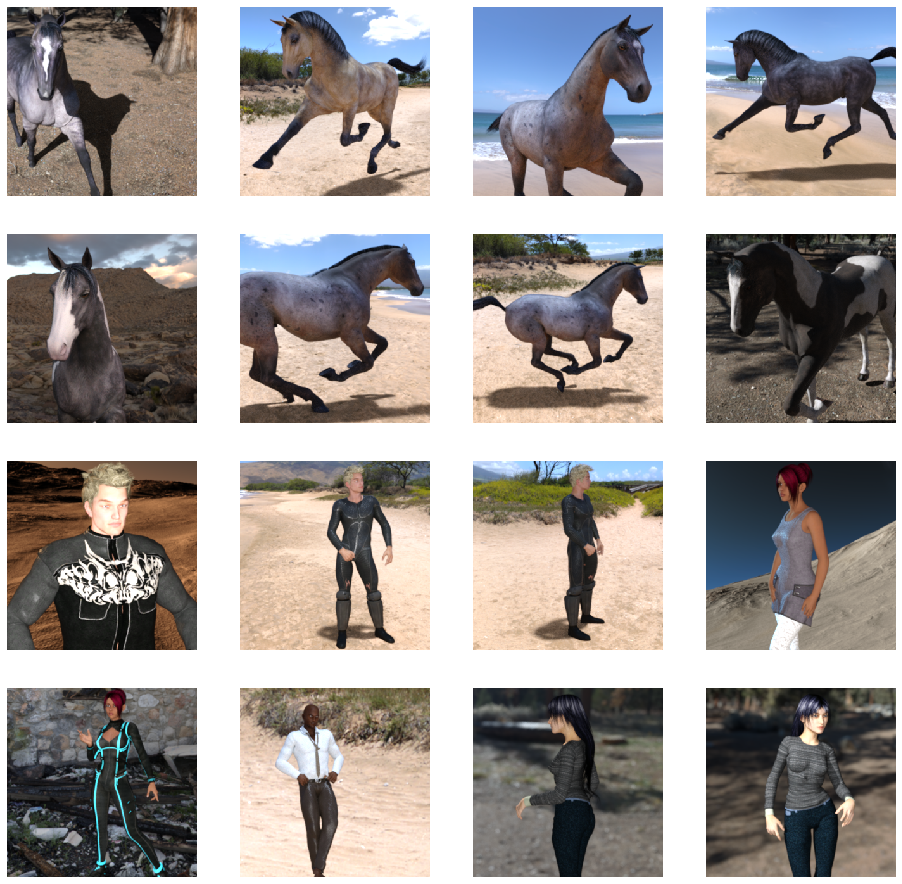

In [12]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]
                
for i, img_path in enumerate(next_horse_pix+next_human_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()



### Building a Model

In [13]:
import tensorflow as tf


In [22]:
model = tf.keras.Sequential([
    # 1st conv
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D(2, 2),
    # 2nd conv
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    # 3rd conv
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    # 4th conv
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    # 5th conv
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    # Flatten
    tf.keras.layers.Flatten(),
    # Dense
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron (0 for horse class, 1 for human class)
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 64)       

We train our model with binary crossentropy ftn with RMSprop optimizer.

In [23]:
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

### Data Processing
Let's set up data generators that will read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. We'll have **one generator for the training imgs** and **one for the validation imgs**. Our generators will yield batches of imgs of size 300x300 and their labels (binary).

In Keras normalization before feeding into the network can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale ` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. Theses generators cna then be used w/ the Keras model methods that accept data generators as inputs: `fit`, `evaluate_generator`, and `predict_generator`. 

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    local_train_target, # src dir
    target_size=(150, 150),
    batch_size=128,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(
    local_val_target,
    target_size=(150, 150),
    batch_size=128,
    class_mode='binary'
)


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


### Training
Let's train for 15 epochs.


In [25]:
history = model.fit(
    train_generator,
    steps_per_epoch=8,
    epochs=15,
    verbose=1,
    validation_data=val_generator,
    validation_steps=2
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/15
8/8 [==============================] - 11s 1s/step - loss: 0.7124 - accuracy: 0.5673 - val_loss: 0.6549 - val_accuracy: 0.7266
Epoch 2/15
8/8 [==============================] - 10s 1s/step - loss: 0.8447 - accuracy: 0.6830 - val_loss: 0.5922 - val_accuracy: 0.6211
Epoch 3/15
8/8 [==============================] - 10s 1s/step - loss: 0.4170 - accuracy: 0.8131 - val_loss: 0.8118 - val_accuracy: 0.6992
Epoch 4/15
8/8 [==============================] - 11s 1s/step - loss: 0.2357 - accuracy: 0.9121 - val_loss: 1.6347 - val_accuracy: 0.7148
Epoch 5/15
8/8 [==============================] - 10s 1s/step - loss: 0.2025 - accuracy: 0.9021 - val_loss: 0.9966 - val_accuracy: 0.8203
Epoch 6/15
8/8 [==============================] - 11s 1s/step - loss: 0.1858 - accuracy: 0.9155 - val_loss: 1.0072 - val_accuracy: 0.8281
Epoch 7/15
8/8 [==============================] - 10s 1s/step - loss: 0.1467 - acc

### Running the Model (Prediction)

In [15]:
import numpy as np
from tensorflow.keras.preprocessing import image

In [25]:
imgdir = '/Users/jisungeeda/Pictures/tmp/'
for f in os.listdir(imgdir):
    img = image.load_img(imgdir + f, target_size=(300, 300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes)
    if classes[0] > 0.5:
        print(f + " is a human")
    else:
        print(f + " is a horse")  

[[0.]]
download.jpeg is a horse
[[1.]]
action-1838330_1920.jpg is a human
[[1.]]
couple-5028352_1920.jpg is a human
[[0.]]
KakaoTalk_Photo_2020-05-08-16-33-34.jpeg is a horse
[[1.]]
female-4875046_1920.jpg is a human


### Visualizing Intermediate Representations

In [35]:
import random

In [30]:
# Let's define a new Model that will take an img as input, and will output intermediate representations for all layers in the previous model.
#successive_inputs = [layer.input for layer in model.layers]
#print(successive_inputs)
successive_outputs = [layer.output for layer in model.layers]
print(successive_outputs)
# define visualization_model
visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs)

[<tf.Tensor 'conv2d/Identity:0' shape=(None, 298, 298, 16) dtype=float32>, <tf.Tensor 'max_pooling2d/Identity:0' shape=(None, 149, 149, 16) dtype=float32>, <tf.Tensor 'conv2d_1/Identity:0' shape=(None, 147, 147, 32) dtype=float32>, <tf.Tensor 'max_pooling2d_1/Identity:0' shape=(None, 73, 73, 32) dtype=float32>, <tf.Tensor 'conv2d_2/Identity:0' shape=(None, 71, 71, 64) dtype=float32>, <tf.Tensor 'max_pooling2d_2/Identity:0' shape=(None, 35, 35, 64) dtype=float32>, <tf.Tensor 'conv2d_3/Identity:0' shape=(None, 33, 33, 64) dtype=float32>, <tf.Tensor 'max_pooling2d_3/Identity:0' shape=(None, 16, 16, 64) dtype=float32>, <tf.Tensor 'conv2d_4/Identity:0' shape=(None, 14, 14, 64) dtype=float32>, <tf.Tensor 'max_pooling2d_4/Identity:0' shape=(None, 7, 7, 64) dtype=float32>, <tf.Tensor 'flatten/Identity:0' shape=(None, 3136) dtype=float32>, <tf.Tensor 'dense/Identity:0' shape=(None, 512) dtype=float32>, <tf.Tensor 'dense_1/Identity:0' shape=(None, 1) dtype=float32>]


Let's prepare a random input img from the training set.

In [33]:
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]

In [47]:
# Randomly choose image file among training set.
img_path = random.choice(horse_img_files + human_img_files)
img = image.load_img(img_path, target_size=(300, 300)) # This is a PIL image (what is PIL..?)

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

# Rescale by 1/255.
x /= 255

# Let's run our img through our network, thus obtaining all intermediate representations for this img.
successive_feature_maps = visualization_model.predict(x)

Now let's display our representations.

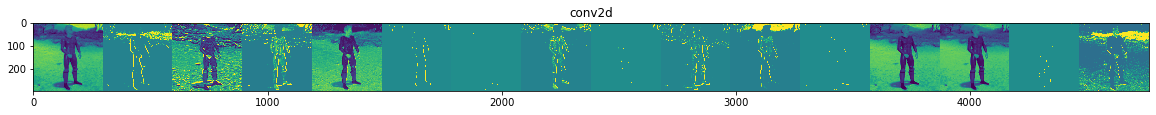

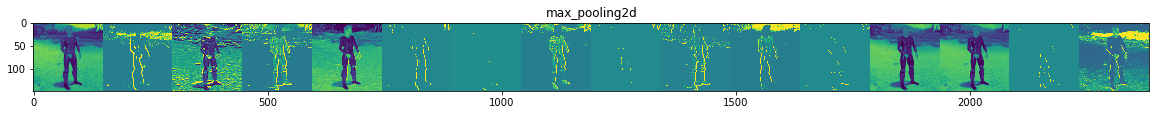

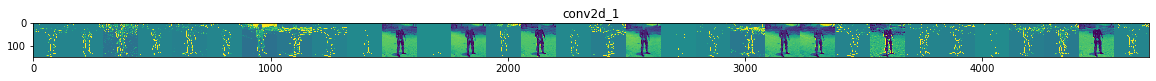

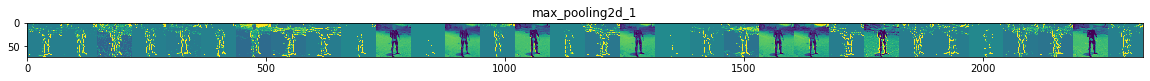

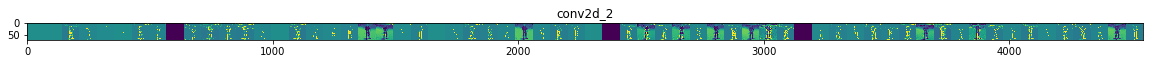

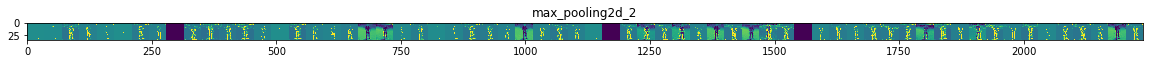

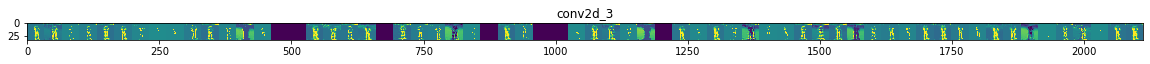

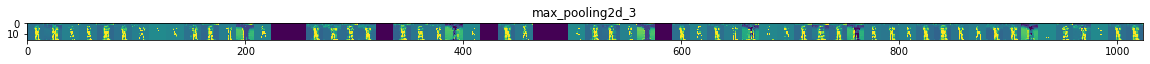

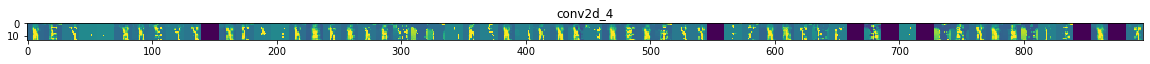

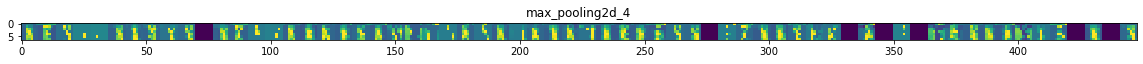

In [49]:
layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1] # num of feature maps
        # Feature map has size of (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our imgs in this mtx
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64 # Why 64? is img w/ std=64 visually palatable?
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i*size:(i+1)*size] = x
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')